### Amazon Prodcut Sentiment Analysis:

Goals: 
    
    1. Perform sentiment analysis using the following techniques:
        a. Logistic Regression with TFIDF vectorizer
        b. Logistic Regression with TFIDF vectorizer and n-grams techniques
        c. SVM classifier with TFIDF vectorizer and n-grams techniques
        d. Naive Bayes Classifier with TFIDF vectorizer and n-grams techniques
    2. Analyzing the performance metrics of each of those above models

#### Step1: Importing required packages and loading the required dataset:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from textblob import Word
import re
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import textblob
from textblob import TextBlob
#from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

I have used 5-core Home and Kitchen reviews dataset. It is subset of the data in which all users and items have at least 5 reviews.

In [2]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Home_and_Kitchen_5.json.gz')

#### Data processing for further analytics and modeling:

In [3]:
df.isna().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

There are no any missing values in any variable except that in reviewerName variable. We do not need reviewerName variable in our analysis.  So, We will continue using all data for our further analysis.

Trying to understand the customer sentiment in multiple directions. I would like to start with Logistic Regression and will see how it works. 
1. Feature extraction/Feature engineering. In this process let's see how we can use 'helpful' variable to understand customer preferences.

In [4]:
# Make new two columns out of 'helpful' column
df[['helpfulfirstelement', 'helpfulsecondelement']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [5]:
# Remove any duplicates
df = df.drop_duplicates(subset= ['reviewerID', 'asin', 'unixReviewTime'], keep = 'first')
# Adding helpful percentage and upvote
df['helpfulPercent'] = np.where(df['helpfulsecondelement'] > 0, df['helpfulfirstelement']/df['helpfulsecondelement'], -1)
df['upvotePercent'] = pd.cut(df['helpfulPercent'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)


In [6]:
df_new = df.groupby(['overall', 'upvotePercent']).agg({'overall': 'count'}).rename(columns = {'overall': 'reviews_count'}).reset_index()

Here I am planning to use reviews text and overall score columns for my further modeling. Here for simplicity I am planning to take two classes by neglecting the overall rating of 3. I will classify overall rating score of [1 and 2] as 0 and overall rating score of [4 and 5] as 1. Finally, I will use reviews text and predict the overall score of either 0 or 1.

In [7]:
df_model = df[df['overall'] != 3]

In [8]:
df_model.head(5).T

,0,1,2,3,4
reviewerID,APYOBQE6M18AA,A1JVQTAGHYOL7F,A3UPYGJKZ0XTU4,A2MHCTX43MIMDZ,AHAI85T5C2DH3
asin,0615391206,0615391206,0615391206,0615391206,0615391206
reviewerName,Martin Schwartz,Michelle Dinh,mirasreviews,"M. Johnson ""Tea Lover""",PugLover
helpful,"[0, 0]","[0, 0]","[26, 27]","[14, 18]","[0, 0]"
reviewText,My daughter wanted this book and the price on ...,I bought this zoku quick pop for my daughterr ...,There is no shortage of pop recipes available ...,This book is a must have if you get a Zoku (wh...,This cookbook is great. I have really enjoyed...
overall,5,5,4,5,4
summary,Best Price,zoku,"Excels at Sweet Dessert Pops, but Falls Short ...",Creative Combos,A must own if you own the Zoku maker...
unixReviewTime,1382140800,1403049600,1367712000,1312416000,1402099200
reviewTime,"10 19, 2013","06 18, 2014","05 5, 2013","08 4, 2011","06 7, 2014"
helpfulfirstelement,0,0,26,14,0


In [9]:
X = df_model['reviewText']
y = df_model['overall'].map({1:0, 2:0, 4:1, 5:1})

Initially, I will start with applying simple logistic regression to predict whether the rating is either positive (1) or negative (0).

#### Sentiment analysis:

Let's detect the sentiment of the review. Before applying any machine learning models, ,let's check the sentiment of the first few reviews

In [10]:
df['reviewText'][:5].apply(lambda x: TextBlob(x).sentiment)

0                                 (0.9, 0.65)
1                  (0.3916666666666666, 0.55)
2     (0.2908062770562771, 0.572667748917749)
3    (0.3873809523809524, 0.7209523809523809)
4    (0.2822222222222222, 0.6692592592592592)
Name: reviewText, dtype: object

It returns a tuple representing polarity and subjectivity of each review. Here I only extract polarity as it indicates the sentiment as value nearer to 1 means positive sentiment and values nearer to -1 means a negative sentiment. This can also work as a feature for building a machine learning. And I will use it for later building Naive Bayes model.

Let's start with simple Logistic regression and the TFIDF vectorizer for text feature engineering. Then eventually, I will build Naive bayes model to predict the sentiment.

In [11]:
def text_process(text):
    text = text.lower()
    text = re.sub('[^a-z]+', ' ', text).strip()
    return text

In [12]:
X = X.apply(lambda x: text_process(x))

In [13]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english')

Write a function to perform TfidfVectorizer for feature extraction and perform different machine learning models on those features.

In [14]:
def model_fit(X, y, feature_model,ml_model,coef_show=1):
    
    X_features = feature_model.fit_transform(X)
    print('# features: {}'.format(X_features.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    
    if coef_show == 1: 
        w = feature_model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('Top 10 positive features (variables)')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('Top 10 negative features (variables)')        
        print(coeff_df.tail(20).to_string(index=False))
       

Let's look at the baseline model performance and will see how it performs. Also, look at the top ten text (word) features for both positive and negative coefficients. DummyClassifier() is classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other(real) classifiers. 

In [15]:
model_fit(X, y, tfidf,DummyClassifier(),coef_show=0)

# features: 1000
accuracy of the model:  0.817685664939551

              precision    recall  f1-score   support

           0       0.10      0.10      0.10     10233
           1       0.90      0.90      0.90     91092

   micro avg       0.82      0.82      0.82    101325
   macro avg       0.50      0.50      0.50    101325
weighted avg       0.82      0.82      0.82    101325



The baseline accuracy of the model is 82%.

In [16]:
model_fit(X, y, tfidf,LogisticRegression(),coef_show=1)

# features: 1000
accuracy of the model:  0.9299481865284974

              precision    recall  f1-score   support

           0       0.75      0.45      0.57     10233
           1       0.94      0.98      0.96     91092

   micro avg       0.93      0.93      0.93    101325
   macro avg       0.85      0.72      0.76    101325
weighted avg       0.92      0.93      0.92    101325


Top 10 positive features (variables)
Coefficient       Word
   9.816006       love
   9.326581    perfect
   8.949654       easy
   8.826484     highly
   8.698433      great
   7.347961    pleased
   7.305565  excellent
   7.082081       glad
   6.487805  perfectly
   5.846966       best
   5.696329      works
   5.628425      loves
   5.444193    amazing
   5.329842     sturdy
   5.272612    awesome
   5.259950      helps
   5.133468  satisfied
   5.082950       nice
   5.080025      happy
   5.049947      handy

Top 10 negative features (variables)
Coefficient           Word
  -3.118974          money

The accuracy has improved from 82% to 93% with Logistic regression. When it comes to top 10 text features for both positive and negative coefficients do make sense. Now, I will add n-grams keyword argument to the TFIDF function and then I will run Logistic Regression model again.

In [17]:
tfidf_n_grams = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english', ngram_range=(1, 2))

In [18]:
model_fit(X, y, tfidf_n_grams,LogisticRegression(),coef_show=1)

# features: 1000
accuracy of the model:  0.9298692326671602

              precision    recall  f1-score   support

           0       0.75      0.46      0.57     10233
           1       0.94      0.98      0.96     91092

   micro avg       0.93      0.93      0.93    101325
   macro avg       0.85      0.72      0.77    101325
weighted avg       0.92      0.93      0.92    101325


Top 10 positive features (variables)
Coefficient              Word
   9.849634              love
   9.224187           perfect
   8.078449             great
   8.068077              easy
   7.398137           pleased
   7.350216         excellent
   7.088916              glad
   6.738402  highly recommend
   6.462057         perfectly
   5.876544              best
   5.608813             works
   5.597946             loves
   5.496429           amazing
   5.271526            sturdy
   5.246291           awesome
   5.231251             helps
   5.207749              nice
   5.163013         satisfied
   5

There is no big difference by introducing n-grams here in this model for Logistic regression.

Let's check if there is any class imbalance here. If there is any class imbalance, then I will resolve that issue and will run the model again and will check the model performance.

In [19]:
y.value_counts()

1    455204
0     51419
Name: overall, dtype: int64

If we check the above value counts, the target values are skewed towards positive side. In order to address this issue, resampling the data has to be performed. I will use oversampling to combat class imbalance. Smote is especially preferable since it's a well-made package with it's own pipeline function compatible with other python modules. Also, before applying SMOTE technique to balance the class, I would like lemmatize the review text and pass it to TFIDF vectorizer.

In [20]:
X = df_model['reviewText']
X = X.apply(lambda x: text_process(x))
X = X.apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

In [21]:
X_features = tfidf_n_grams.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
X_test_smote, y_test_smote = sm.fit_sample(X_test, y_test)

In [22]:
def class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, ml_model):
    
    clf = ml_model.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test_smote)
    accuracy = clf.score(X_test_smote, y_test_smote)
    model_performance = classification_report(y_test_smote, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test_smote)
    roc_auc = roc_auc_score(y_test_smote, validation_pred_proba_grad[:,1])
    
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)
    
       

#### Logistic Regression Modeling:

In [23]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression())

accuracy of the model:  0.8854948842928029

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     91092
           1       0.90      0.87      0.88     91092

   micro avg       0.89      0.89      0.89    182184
   macro avg       0.89      0.89      0.89    182184
weighted avg       0.89      0.89      0.89    182184


ROC_AUC score:  0.9507208182849453


Now, the accuracy is 89% and auc of the ROC curve is 95%

Now apply SVM model to classify and see the model performance metrics.

#### SVM Modeling:

In [24]:
#class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, svm.SVC())

Support Vector Machines are powerful tools, but their compute and storage requirements increase rapidly with the number of training vectors. The core of an SVM is quadratic programming problem (QP), separating support vectors from the rest of the training data. Also, note that for the linear case, the algorithm used in LinearSVC by the liblinear implementation is much more efficient than its libsvm-based SVC counterpart and can scale almost linearly to millions of samples and/or features. SVM - training with nonlinear-kernels, which is default in sklearn's SVC, is complexity-wise approximately: 0(n_samples^2 * n_features). This applies to to the SMO-algorithm used within libsvm, which is the core-solver in sklearn for this type of problem. This changes much when no kernels are used and one uses sklearn.svm.LinearSVC (based on liblinear) or sklearn.linear_model.SGDClassifier.

#### Naive Bayes Modeling:

In [25]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [27]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB())

accuracy of the model:  0.8097966890616081

              precision    recall  f1-score   support

           0       0.81      0.81      0.81     91092
           1       0.81      0.81      0.81     91092

   micro avg       0.81      0.81      0.81    182184
   macro avg       0.81      0.81      0.81    182184
weighted avg       0.81      0.81      0.81    182184


ROC_AUC score:  0.8784503473831273


In [29]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB())

accuracy of the model:  0.6622261010846178

              precision    recall  f1-score   support

           0       0.74      0.50      0.60     91092
           1       0.62      0.82      0.71     91092

   micro avg       0.66      0.66      0.66    182184
   macro avg       0.68      0.66      0.65    182184
weighted avg       0.68      0.66      0.65    182184


ROC_AUC score:  0.775709907161675


Write a function to extract model predictions and prediction probabilities. Also, write a function to draw ROC curves to evaluate the performance of each model outputs.

In [30]:
def model_pred(X_train, y_train, X_test, y_test, model):
    #if model == LogisticRegression:
    #    model = model()
    #else:
    #    model = model(n_estimators = trees)
    model = model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

In [31]:
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, model1, model2, model3):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return

In [32]:
y_pred1, y_pred_probs1 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, LogisticRegression)
y_pred2, y_pred_probs2 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, MultinomialNB)
y_pred3, y_pred_probs3 = model_pred(X_train_smote, y_train_smote, X_test_smote, y_test_smote, BernoulliNB)

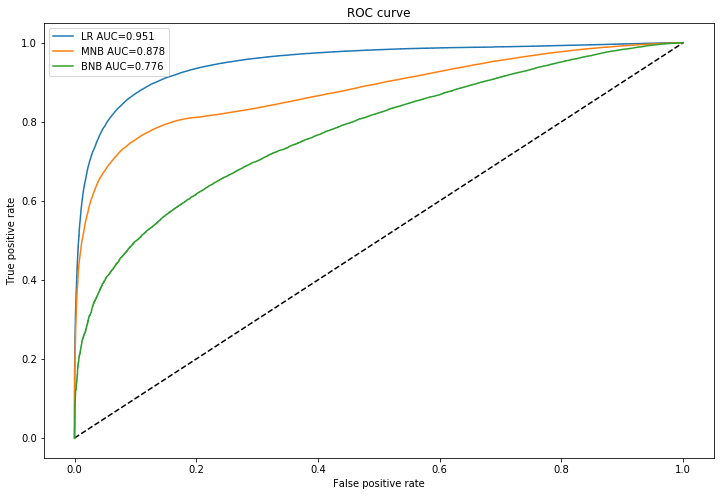

In [33]:
ROC_curve_plots(y_test_smote,y_pred_probs1, y_pred_probs2,y_pred_probs3, 'LR', 'MNB','BNB')

From the above chart, we can say that Logistic regression got an auc of 95%, Multinomial Naive Bayes got an auc of 88%, and Binomial Naive Bayes got an auc of 78%. Thus, we can say that Logistic regression is the model to consider to classify positive or negative sentiment in this particular case of dataset. 

#### Implementing LinearSVM model (SGDclassifier with 'log' loss function):

I tried using 'hinge' loss function but it couldn't return predicted probabilities for the given dataset. So, I decided to use 'log' loss function.

In [61]:
from sklearn.linear_model import SGDClassifier

In [57]:
def model_pred_svm(X_train, y_train, X_test, y_test, model):
    #if model == LogisticRegression:
    #    model = model()
    #else:
    #    model = model(n_estimators = trees)
    model = model(loss = 'log')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

In [58]:
y_pred4, y_pred_probs4 = model_pred_svm(X_train_smote, y_train_smote, X_test_smote, y_test_smote, SGDClassifier)

In [59]:
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, y_pred_probs4, model1, model2, model3, model4):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    fpr4, tpr4, _ = roc_curve(y_test, y_pred_probs4)
    auc4 = roc_auc_score(y_test, y_pred_probs4)    
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.plot(fpr4, tpr4, label=f'{model4} AUC={round(auc4,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return

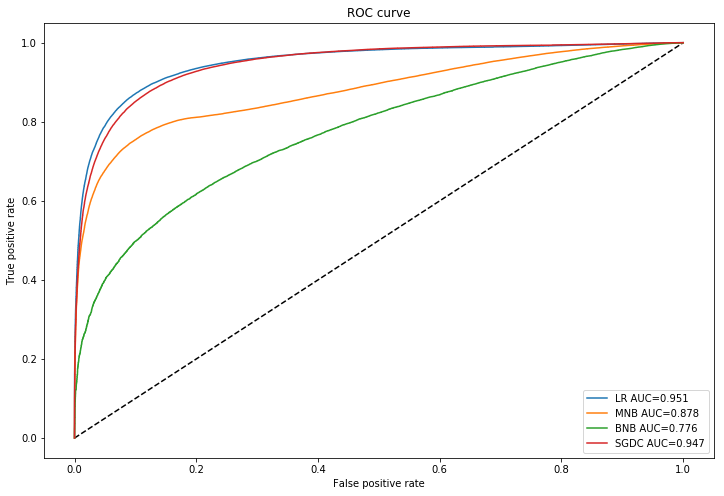

In [60]:
ROC_curve_plots(y_test_smote,y_pred_probs1, y_pred_probs2, y_pred_probs3, y_pred_probs4, 'LR', 'MNB','BNB', 'SGDC')

Both Logistic regression classifier and SGD classifiers got almost the same AUC value of 95%. The reason why they both got same AUC is I have used 'log' loss function in SGDClassifier. I tried using 'hinge' loss function (refers to linear to SVM) but it couldn't return any predicted probabilites.